# UMAP - Spotting Bots 
- UDD/MDS18/PP4
- Final Project: 'Studying Twitter User Accounts: Spotting Suspicious Social Bot Behavior'
- Master Candidate: Marcelo Rovai
- Professors:	   
    - Eduardo Graells-Garrido (Supervisor)
    - Loreto Bravo
    - Leo Ferres

## Main Libraries & Setup

In [1]:
import pandas as pd
from pandas.plotting import table
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import re
import botometer
import tweepy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.float_format', lambda x: '%.f' % x)
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})

In [ ]:
mashape_key = 'botomer_mashape_key'
twitter_app_auth = {
    'access_token' : "twitter_acc_access_token",
    'access_token_secret' : "twitter_acc_access_token_secret",
    'consumer_key' : "twitter_acc_consumer_key",
    'consumer_secret' : "twitter_acc_consumer_secret",    
}
bom = botometer.Botometer(wait_on_ratelimit = True, mashape_key = mashape_key, **twitter_app_auth)

## Main Functions

In [5]:
def get_twts_per_day(tweets):
    tw_day = []
    for d in range (1, 31):
        tw_day.append(len(tweets[tweets.day == d]))
    return tw_day

In [6]:
def get_max_tweet_day(tweets, user_list):
    max_twt_day = []
    for user_name in user_list:
        t = tweets[tweets.user == user_name].reset_index(drop=True)
        twt_day = get_twts_per_day(t)
        max_twt_day.append(max(twt_day))
    max_tweet_day_user = dict(zip(user_list, max_twt_day))
    max_tweet_day_user = sorted(max_tweet_day_user.items(), key=lambda x:x[1], reverse=True)
    return max_tweet_day_user

In [7]:
def verif_acc_active(user):
    url = "https://twitter.com/"
    try:
        html = urlopen(url+user).read()
        return True 
    except:
        return False

In [8]:
def get_hashtags(tweets):
    hashtags = []
    hashtag_pattern = re.compile(r"#[a-zA-Z]+")
    hashtag_matches = list(tweets['text'].apply(hashtag_pattern.findall))
    hashtag_dict = {}
    cnt = 0
    for match in hashtag_matches:
        for singlematch in match:
            if singlematch not in hashtag_dict.keys():
                hashtag_dict[singlematch] = 1
                cnt +=1
            else:
                hashtag_dict[singlematch] = hashtag_dict[singlematch]+1
                cnt +=1
    hashtag_ordered_list =sorted(hashtag_dict.items(), key=lambda x:x[1], reverse=True)
    return hashtag_ordered_list, len(hashtag_ordered_list), cnt

In [9]:
def get_mentions(tweets):
    mentions = []
    mention_pattern = re.compile(r"@[a-zA-Z_]+")
    mention_matches = list(tweets['text'].apply(mention_pattern.findall))
    mentions_dict = {}
    cnt = 0
    for match in mention_matches:
        for singlematch in match:
            if singlematch not in mentions_dict.keys():
                mentions_dict[singlematch] = 1
                cnt +=1
            else:
                mentions_dict[singlematch] = mentions_dict[singlematch]+1
                cnt +=1
    mentions_ordered_list =sorted(mentions_dict.items(), key=lambda x:x[1], reverse=True)
    return mentions_ordered_list, len(mentions_ordered_list), cnt

In [10]:
def print_user_features(tweets, user_name, prt=True, ver_act=False): 
    if ver_act == False:
        active_acc = "Not checked" 
    else:
        active_acc = verif_acc_active(user_name)
        if verif_acc_active(user_name):
            active_acc = "Active"
        else:
            active_acc = "Not Active"        
        
    t = tweets[tweets.user == user_name].reset_index(drop=True)

    user =  t.user.values[0]
    name = t.name.values[0]
    user_id = t.user_id.values[0]
    default_prof_image = t.default_prof_image.values[0]
    photo_url = t.image.values[0]
    acc_verif = t.verified.values[0]
    location = t.location.values[0]
    default_profile = t.default_profile.values[0]
    descr = t.description.values[0]  
    tws_cnt = t.tweets_cnt.values[0]
    frs_cnt = t.following.values[0]
    fols_cnt = t.followers.values[0]
    fav_cnt = t.favourites.values[0]
    
    if default_prof_image == False:
        if photo_url == 'http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png':
            default_prof_image = True
        else:
            default_prof_image = False
    
    if location == '': 
        local_bol = False
    else:
        local_bol = True
    
    if descr == '':
        descr_bol = False
    else:
        descr_bol = True
    
    tweets_analysed = len(t)
    
    last_tweet_date = t.created_at.values[-1]
    older_tweet_date = t.created_at.values[0]
    account_created_date = t.acc_creation.values[0]
    
    delta = last_tweet_date - account_created_date
    days = delta.astype('timedelta64[D]')
    account_age_days = days / np.timedelta64(1, 'D')
    
    recent_delta = last_tweet_date - older_tweet_date
    days = recent_delta.astype('timedelta64[D]')
    recent_age_days = days / np.timedelta64(1, 'D')  
    
    ave_acc_tw_day = round(tws_cnt/account_age_days, 2)
    ave_recent_tw_day = round(tweets_analysed/recent_age_days, 2)
    tw_day = get_twts_per_day(t)
    max_tweet_day = max(tw_day)
    peak_day = [i for i, j in enumerate(tw_day) if j == max_tweet_day]
    peak_day = peak_day[0] + 1

    if fav_cnt != 0:    
        rt_fv_idx = round(t.retweet_cnt.values[0]/fav_cnt, 2)
    else:
        rt_fv_idx = 0    
    
    if frs_cnt != 0:    
        fl_fw_idx = round(fols_cnt/frs_cnt, 2)
    else:
        fl_fw_idx = 0
    
    RT_tweets = t[t['RT'] == True]
    rt_tweets_cnt =  len(RT_tweets)   
    rt_ratio = round(rt_tweets_cnt/tweets_analysed*100)

    ment_tweets = t[t['num_mentions'] !=0]
    ment_tweets_cnt = len(ment_tweets)
    ment_ratio = round(ment_tweets_cnt/tweets_analysed*100)
    
    hash_tweets = t[t['num_hashtags'] !=0]
    hash_tweets_cnt = len(hash_tweets)
    hash_ratio = round(hash_tweets_cnt/tweets_analysed*100)
    
    mentions, unique_mentions_cnt, ment_cnt = get_mentions(t)
    hashtags, unique_hashtags_cnt, hash_cnt = get_hashtags(t)
    
    try:
        ment_idx = round(unique_mentions_cnt/ment_cnt, 2)
    except:
        ment_idx = 0.0
    try:
        hash_idx = round(unique_hashtags_cnt/hash_cnt, 2) 
    except:
        hash_idx = 0.0
        
    mean_urls = round(t.num_urls.values.mean(), 2)
    mean_lenght = round(t.lenght.values.mean(),0)
 
    # New Features   
    user_len = len(user)
    name_len = len(name)
    descr_len = len(descr)
    
    temp = re.findall(r'\d+', user)
    if len(temp) == 0:
        user_len_num = 0
    else:
        user_len_num = len(temp[0])
    
    try:
        simil_name = 100*(jaccard_similarity(user, name))
    except:
        simil_name = 0          
    
    if frs_cnt != 0:    
        fols_frs_ratio = round(fols_cnt/frs_cnt, 2)
    else:
        fols_frs_ratio = 0
    
    metrics = [
        user, user_id, name, default_prof_image, photo_url, acc_verif, 
        location, local_bol, default_profile, descr, descr_bol, active_acc, tws_cnt, frs_cnt, 
        fols_cnt, fav_cnt, fl_fw_idx, last_tweet_date, older_tweet_date, 
        tweets_analysed, account_age_days, ave_acc_tw_day, 
        ave_recent_tw_day, max_tweet_day, ment_tweets_cnt, hash_tweets_cnt, 
        unique_mentions_cnt, unique_hashtags_cnt, ment_idx, hash_idx, 
        rt_ratio, mean_urls, mean_lenght, recent_age_days, user_len, name_len,
        user_len_num, simil_name, descr_len
    ]
    
    if prt == True:   
        print("\nInfo Data for @" + user)
        print("\nName:                      ", name)
        print("Name Length:               ", name_len)
        print("@user number Numeric Chars:", user_len_num)
        print("@user and name similarity: ", simil_name)
        print("User Id:                   ", user_id)
        print("Default_Photo:             ", default_prof_image)
        print("Photo URL:                 ", photo_url)
        print("Acc Verified:              ", acc_verif)
        print("Has Location:              ", local_bol)
        print("Location:                  ", location)
        print("default_profile:           ", default_profile)
        print("Has Description:           ", descr_bol)
        print("Description:               ", descr) 
        print("Description length:        ", descr_len) 
        print("Account Active:            ", active_acc)

        print("\nNumber of Tweets analyzed:         ", tweets_analysed)
        print("Last Tweet:                        ", last_tweet_date)
        print("Older Tweet Analyzed:              ", older_tweet_date)
        print("Account Active age (in days)        {0:,}".format(account_age_days))
        print("Average recent tweets per day:      {}".format(ave_recent_tw_day))
        print("Maximum Recent Tweets Per Day:      {} at day {}".format(max_tweet_day, peak_day))
        print("Average tweets per day since start: {}".format(ave_acc_tw_day))
        print("Total Tweets since start:           {0:,}".format(tws_cnt))
        print("Followers_count:                    {0:,}".format(fols_cnt))
        print("Friends_following_count             {0:,}".format(frs_cnt))
        print("Followers/Following_index:          {}".format(fl_fw_idx)) 
        print("Favourites (Like) count:            {0:,}".format(fav_cnt))       
        print("Retweet_Like_index:                 {}".format(rt_fv_idx)) 
        print("Retweet Ratio:                      {}%".format(rt_ratio))
        print("unique mentions cnt:                {}".format(unique_mentions_cnt)) 
        print("Mention Ratio:                      {}%".format(ment_ratio))
        print("Mention index:                      {}".format(ment_idx))
        print("unique hashtags cnt:                {}".format(unique_hashtags_cnt))     
        print("Hashtag Ratio:                      {}%".format(hash_ratio))
        print("Hashtag Index:                      {}".format(hash_idx))
        print("Average URLs per tweet:             {}".format(mean_urls))
        print("Average text length per tweet:      {}".format(mean_lenght))
    
    return tw_day, peak_day, metrics, mentions, hashtags

In [11]:
def plot_feature(df, feat, kde=True, prt=False, save_file_name=None, x_max = None):
    f, axes = plt.subplots(ncols=1, figsize=(10, 4))
    sns.despine(left=True)
    sns.distplot(df[feat],
                 color="m",
                 hist=False,
                 kde=kde,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 })
    plt.suptitle(feat + " distribution", fontsize=20)
    plt.xlabel(feat,fontsize=15)
    plt.setp(axes, yticks=[])
    plt.xlim(0, x_max)

    if prt == True:
        plt.savefig("../images/"+save_file_name, bbox_inches='tight')

In [12]:
def get_info_data(tweets, user_name, ver_act=True, prt=False):
    tw_day, peak_day, metrics, mentions, hastags = print_user_features(
        tweets, user_name, ver_act=ver_act)
    print(
        "\n \t[Tweets Sample at Peak Day] \n",
        tweets[(tweets.user == user_name)
               & (tweets.day == peak_day)].text[:10])
    plot_user_timeline(user_name, tw_day, prt=prt)
    return tw_day, metrics, mentions, hastags

In [55]:
def plot_user_timeline(user_name, tw_day, prt=False):   
    f, axes = plt.subplots(ncols=1, figsize=(10, 4))
    plt.suptitle("@"+user_name+" - Number of Tweets per day", fontsize = 20)
    sns.despine()
    plt.xlabel("day of the month",fontsize=15)
    plt.ylabel("# tweets",fontsize=15)
    plt.bar(range(1, 31), tw_day);
    
    if prt == True:
        plt.savefig("../images/"+user_name+" - Timeline.png", bbox_inches='tight')

In [14]:
def plot_feat_comp(feat, prt=False, save_file_name=None, x_max = None):
    feat1 = hf[feat]
    feat2 = lf[feat]
    fig, axes = plt.subplots(ncols=1, figsize=(10, 5))
    #fig = plt.figure(figsize = (10,5))
    sns.distplot(feat1,
                 color="m",
                 label='High Frequency',
                 hist=False,
                 kde=True,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 })
    plt.xlim(0, x_max)
    
    sns.distplot(feat2,
                 color="g",
                 label='Low Frequency',
                 hist=False,
                 kde=True,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 })
    plt.xlim(0, x_max)
    plt.suptitle(feat+' distribution', fontsize=16)
    sns.despine(left=True)
    plt.setp(axes, yticks=[])
    
    if prt == True:
        plt.savefig("../images/"+save_file_name, bbox_inches='tight')

In [15]:
def plot_feat_comp_2_graph(feat, prt=False, save_file_name=None):
    low_freq = lf[feat]
    high_freq = hf[feat]
    f, axes = plt.subplots(ncols=2, figsize=(10, 4))
    sns.despine(left=True)
    sns.distplot(high_freq,
                 color="m",
                 label='High Frequency',
                 hist=False,
                 kde=True,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 },
                 ax=axes[0])
    sns.distplot(low_freq,
                 color="g",
                 label='Low Frequency',
                 hist=False,
                 kde=True,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 },
                 ax=axes[1])
    plt.suptitle(feat + " distribution", fontsize=16)
    plt.setp(axes, yticks=[])
    
    if prt == True:
        plt.savefig("../images/"+save_file_name, bbox_inches='tight')

In [16]:
def get_botometer_details(user, prt=True):
    try:
        result = bom.check_account(user)
        score = result['scores']
        score_eng = score["english"]
        score_unl = score["universal"]
        cap = result['cap']
        cap_eng = cap["english"]
        cap_unl = cap["universal"]
        cat = result['categories']
        bt_friend = cat['friend']
        bt_network = cat['network']
        bt_sent = cat['sentiment']
        bt_temp = cat['temporal']
        bt_user = cat['user']
        if prt == True:
            print_botometer_details(result)
        return score_eng, score_unl, cap_eng, cap_unl, bt_friend, bt_network, bt_sent, bt_temp, bt_user
    except:
        if prt == True:
            print('{} is not a Twitter user or is blocked'.format(user))
        return 0, 0, 0, 0, 0, 0, 0, 0, 0

In [17]:
def print_botometer_details(result):
    user_data = result['user']
    print("\nBotometer Result for @" + user_data['screen_name'])
    print("\nUser Id:     ", user_data["id_str"])
    score = result['scores']
    print("Score_eng:   ", score["english"])
    print("Score_unl:   ", score["universal"])
    cap = result['cap']
    print("CAP_eng:     ", cap["english"])
    print("CAP_unl:     ", cap["universal"])
    cat = result['categories']
    cat = result['categories']
    print('\nCategories:')
    print("Friend:     ", cat['friend'])
    print("Network:    ", cat['network'])
    print("Sentiment:  ", cat['sentiment'])
    print("Temporal:   ", cat['temporal'])
    print("User:       ", cat['user'])
    print("\nProbability of @{} be a bot is {}%".format(
        user_data['screen_name'], round(score["universal"] * 100)))

## Loading Tweets Dataset

In [18]:
ls ../data/

20_tweets_nov_2017.csv             50_user_metrics_final.csv
30_tweets_nov_2017_final.csv       60_user_metrics_label.csv
40_user_metrics.csv                df_user_description.csv
45_user_adit_clean_metrics.csv     select_tweet_feat_description.csv


In [19]:
tweets = pd.read_csv("../data/30_tweets_nov_2017_final.csv", lineterminator='\n')
tweets.shape

(1601643, 36)

In [20]:
del tweets['Unnamed: 0']

In [21]:
tweets.description.fillna('', inplace=True)
tweets.location.fillna('', inplace=True)

In [22]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'], infer_datetime_format = "%d/%m/%Y", utc  = False)
tweets['acc_creation'] = pd.to_datetime(tweets['acc_creation'], infer_datetime_format = "%d/%m/%Y", utc  = False)

In [23]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601643 entries, 0 to 1601642
Data columns (total 35 columns):
user_id               1601643 non-null int64
user                  1601643 non-null object
name                  1601576 non-null object
description           1601643 non-null object
verified              1601643 non-null bool
protected             1601643 non-null bool
location              1601643 non-null object
lang                  1601643 non-null object
followers             1601643 non-null int64
following             1601643 non-null int64
favourites            1601643 non-null int64
lists                 1601643 non-null int64
tweets_cnt            1601643 non-null int64
acc_creation          1601643 non-null datetime64[ns, UTC]
default_profile       1601643 non-null bool
default_prof_image    1601643 non-null bool
image                 1601643 non-null object
text                  1601643 non-null object
tweet_id              1601643 non-null int64
created_at     

##  UMAP Possible Bots Users Analysis

In [24]:
bots_users_lst = [
    'Aptimate', 'EncuestaExpress', 'jaimeantonio67', 'comandoguillie4',
    'RResponsablecl', 'mas_estudiantil', 'arqmneira', 'Maria_sepul66',
    'cazadorandino90', 'DulceViborita', 'FresiaPavez1', 'Sirius4321',
    'viejofasho', 'Ignacio90415476', 'EstudioOsorno', 'NathalySeplved3',
    'MSP_LasCondes', 'ElCentinelaMPE', 'caco_sanmartin', 'maasma58',
    'Dolores09072598', 'SoleAitkenP', 'JuanManuelCorn5', 'Trab_vXguillier',
    'c_alvan_0207', 'Santiag87306226', 'Edelarosacris', 'andres20der',
    'mrgrtgautier', 'BassaRiveros', 'Conapro_jjcc', 'SebastianFont20',
    'ChristianPolo7', 'almquin', 'chunchitomauro', 'Atletadelgol32',
    'laviedej', 'Ange_GossowF', 'Sumate_Guillier', 'solgensen',
    'FelipeAlegreJ', 'BarbManriquez', 'jav_ast'
]

### @mrgrtgautier


Info Data for @mrgrtgautier

Name:                       Marianne
Name Length:                8
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    927682098122711042
Default_Photo:              True
Photo URL:                  http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            False
Description:                
Description length:         0
Account Active:             Active

Number of Tweets analyzed:          55
Last Tweet:                         2017-11-19T14:48:07.000000000
Older Tweet Analyzed:               2017-11-06T23:57:23.000000000
Account Active age (in days)        12.0
Average recent tweets per day:      4.58
Maximum Recent Tweets Per Day:      53 at day 7
Average tweets per day since start: 0.42
Total Tweets since start:           5
Followers_count:  

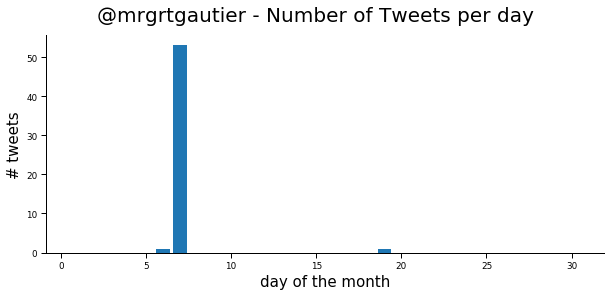

In [25]:
user_name = 'mrgrtgautier'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @ChristianPolo7


Info Data for @ChristianPolo7

Name:                       Christian Polo
Name Length:                14
@user number Numeric Chars: 1
@user and name similarity:  0
User Id:                    930604744485285888
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/930606834813108229/suldiSCt_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                Siempre a la izquierda...
Description length:         25
Account Active:             Active

Number of Tweets analyzed:          227
Last Tweet:                         2017-11-30T23:51:58.000000000
Older Tweet Analyzed:               2017-11-15T21:24:25.000000000
Account Active age (in days)        15.0
Average recent tweets per day:      15.13
Maximum Recent Tweets Per Day:      54 at day 23
Average tweets per day since start: 0.67
Total Tweets since st

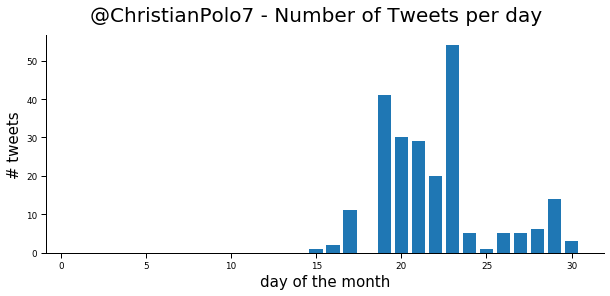

In [26]:
user_name = 'ChristianPolo7'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @Conapro_jjcc


Info Data for @Conapro_jjcc

Name:                       CONAPRÓ
Name Length:                7
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    920112515832565761
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/920113808139571206/kBVbQwZd_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Chile
default_profile:            True
Has Description:            True
Description:                Comisión Nacional de Profesores de las Juventudes Comunistas de Chile (@jjcc_chile)
Description length:         83
Account Active:             Active

Number of Tweets analyzed:          72
Last Tweet:                         2017-11-08T13:35:27.000000000
Older Tweet Analyzed:               2017-11-08T13:35:27.000000000
Account Active age (in days)        22.0
Average recent tweets per day:      inf
Maximum Recent Tweets Per Day:      61 at day 8
Average tweets

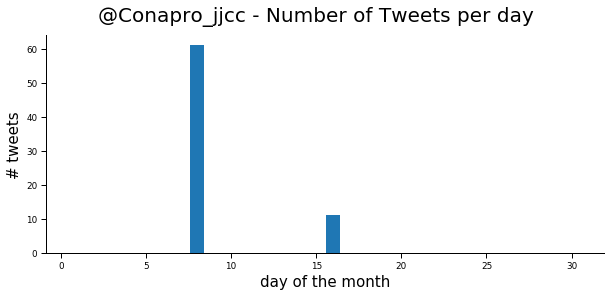

In [27]:
user_name = 'Conapro_jjcc'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @Atletadelgol32


Info Data for @Atletadelgol32

Name:                       Leonardo Gonzalez
Name Length:                17
@user number Numeric Chars: 2
@user and name similarity:  0
User Id:                    931193481162383360
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/931343805432975364/uedmN423_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Valparaíso, Chile
default_profile:            False
Has Description:            True
Description:                Relator deportivo (no profesional todavia) , futuro periodista , locuciones 🙌 ⚽️🎙️📻❤️estudiante , emociones , opinion 100% al publico , buena onda😊😀 , sociable.
Description length:         160
Account Active:             Not Active

Number of Tweets analyzed:          90
Last Tweet:                         2017-11-20T03:33:41.000000000
Older Tweet Analyzed:               2017-11-17T04:02:03.000000000
Account Active age (in days)       

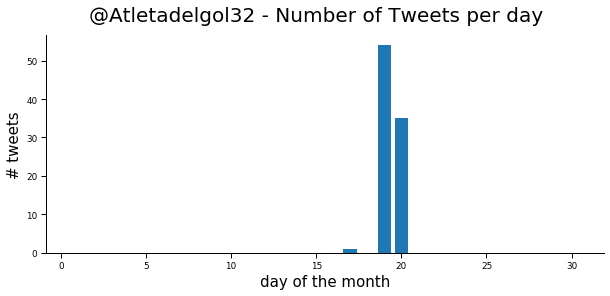

In [28]:
user_name = 'Atletadelgol32'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @ElCentinelaMPE


Info Data for @ElCentinelaMPE

Name:                       El Centinela
Name Length:                12
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    921445622678478848
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/921446439846383616/VJVnqA3F_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Santiago, Chile
default_profile:            False
Has Description:            True
Description:                Noticias y actualidad desde el Magíster en Periodismo UC-El Mercurio.
Description length:         69
Account Active:             Active

Number of Tweets analyzed:          141
Last Tweet:                         2017-11-20T00:44:21.000000000
Older Tweet Analyzed:               2017-11-02T17:00:04.000000000
Account Active age (in days)        30.0
Average recent tweets per day:      8.29
Maximum Recent Tweets Per Day:      114 at day 19
Avera

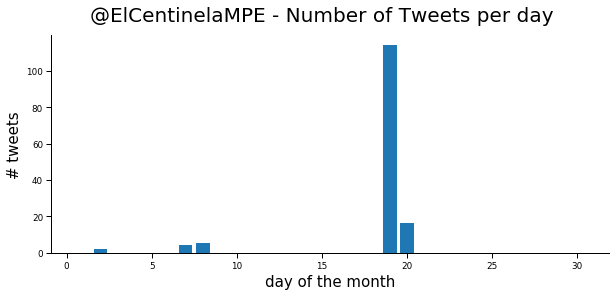

In [29]:
user_name = 'ElCentinelaMPE'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @JuanManuelCorn5


Info Data for @JuanManuelCorn5

Name:                       Juan Manuel Cornejo
Name Length:                19
@user number Numeric Chars: 1
@user and name similarity:  0
User Id:                    902771116560789507
Default_Photo:              True
Photo URL:                  http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png
Acc Verified:               False
Has Location:               True
Location:                   La Reina, Chile
default_profile:            True
Has Description:            True
Description:                Me carga discriminar. Pero confieso que lo hago. Pido perdon por eso. Ayudame Dios poderoso para aprender amar bien.
Description length:         116
Account Active:             Active

Number of Tweets analyzed:          84
Last Tweet:                         2017-11-30T11:27:27.000000000
Older Tweet Analyzed:               2017-11-03T20:23:47.000000000
Account Active age (in days)        92.0
Average recent tweets per day:      3.23

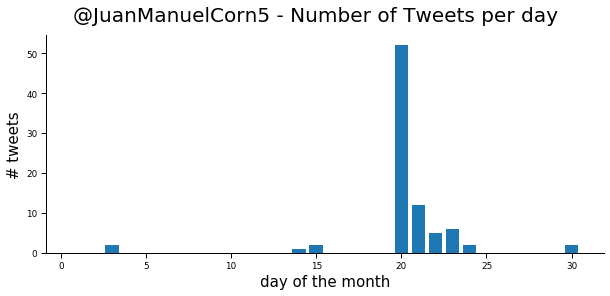

In [30]:
user_name = 'JuanManuelCorn5'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @Santiag87306226


Info Data for @Santiag87306226

Name:                       Santiago Carvajal S
Name Length:                19
@user number Numeric Chars: 8
@user and name similarity:  0
User Id:                    919691533212930048
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/919907532558266369/W2r8KjFl_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                Estudiante de Derecho UA y un ciudadano preocupado por el dia de hoy.
Description length:         69
Account Active:             Not Active

Number of Tweets analyzed:          106
Last Tweet:                         2017-11-29T22:26:51.000000000
Older Tweet Analyzed:               2017-11-06T01:54:58.000000000
Account Active age (in days)        44.0
Average recent tweets per day:      4.61
Maximum Recent Tweets Per Day:      72 at day 6
Average tw

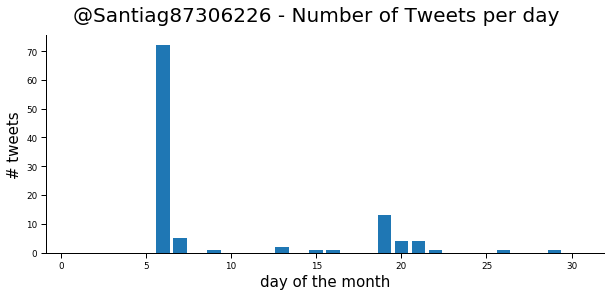

In [31]:
user_name = 'Santiag87306226'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @FelipeAlegreJ


Info Data for @FelipeAlegreJ

Name:                       Felipe Alegre
Name Length:                13
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    899835561669689344
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/900117258051178497/r-LAHy5B_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   San Miguel, Chile
default_profile:            True
Has Description:            True
Description:                Periodista
Description length:         10
Account Active:             Active

Number of Tweets analyzed:          176
Last Tweet:                         2017-11-23T20:47:47.000000000
Older Tweet Analyzed:               2017-11-23T20:47:47.000000000
Account Active age (in days)        93.0
Average recent tweets per day:      inf
Maximum Recent Tweets Per Day:      174 at day 23
Average tweets per day since start: 1.17
Total Tweets since star

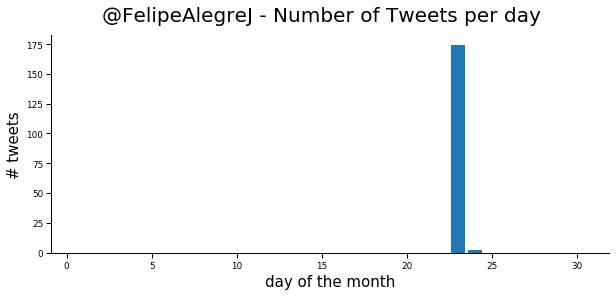

In [32]:
user_name = 'FelipeAlegreJ'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @Trab_vXguillier


Info Data for @Trab_vXguillier

Name:                       Guillier Por Chile
Name Length:                18
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    914987912630083585
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/915014108336066561/2jpojTwe_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                Trabajadores públicos de la región de Valparaíso que apoyamos al futuro presidente de la gente de Chile
Description length:         103
Account Active:             Active

Number of Tweets analyzed:          178
Last Tweet:                         2017-11-29T22:18:36.000000000
Older Tweet Analyzed:               2017-11-03T21:02:31.000000000
Account Active age (in days)        57.0
Average recent tweets per day:      6.85
Maximum Recent Tweets Per Da

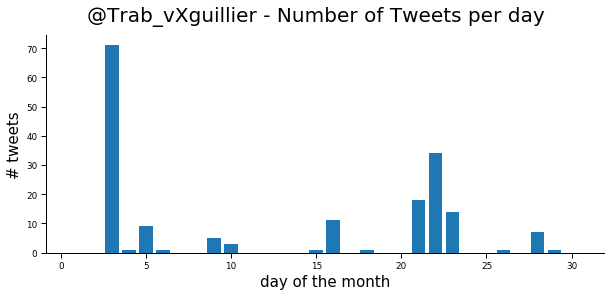

In [33]:
user_name = 'Trab_vXguillier'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

In [34]:
tweets[(tweets.user == user_name)& (tweets.day == 5)].text

128481    Hoy todos a sentarse al sillón a acompañar a @...
128573    Hoy todos a sentarse al sillón a acompañar a @...
129342    Hoy todos a sentarse al sillón a acompañar a @...
129537    Hoy todos a sentarse al sillón a acompañar a @...
131917    Hoy todos a sentarse al sillón a acompañar a @...
134894    Hoy todos a sentarse al sillón a acompañar a @...
137737    Hoy todos a sentarse al sillón a acompañar a @...
140357    Hoy todos a sentarse al sillón a acompañar a @...
419381    Hoy todos a sentarse al sillón a acompañar a @...
Name: text, dtype: object

### @Sumate_Guillier


Info Data for @Sumate_Guillier

Name:                       #SúmateAGuillier
Name Length:                16
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    933384768804110336
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/933385440794632192/MwSY39xo_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Chile
default_profile:            True
Has Description:            True
Description:                Súmate a apoyar la candidatura del próximo Presidente de Chile, Alejandro Guillier.
Description length:         83
Account Active:             Not Active

Number of Tweets analyzed:          530
Last Tweet:                         2017-11-29T13:47:07.000000000
Older Tweet Analyzed:               2017-11-22T18:17:45.000000000
Account Active age (in days)        6.0
Average recent tweets per day:      88.33
Maximum Recent Tweets Per Day:      195 at 

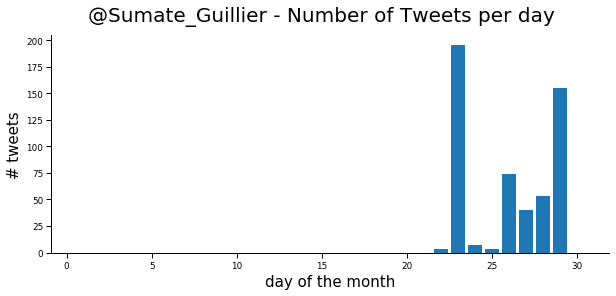

In [35]:
user_name = 'Sumate_Guillier'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @viejofasho


Info Data for @viejofasho

Name:                       viejofachon
Name Length:                11
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    923489618368106496
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/923492228567388160/zljAIxzc_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Ucrania
default_profile:            True
Has Description:            True
Description:                Camino por la derecha,la izq marxista es tóxica para la democracia...anti pinochet...
Disparo con la palabra...
Description length:         111
Account Active:             Active

Number of Tweets analyzed:          319
Last Tweet:                         2017-11-29T11:51:42.000000000
Older Tweet Analyzed:               2017-11-01T13:10:40.000000000
Account Active age (in days)        34.0
Average recent tweets per day:      11.81
Maximum Recent Tweets Per

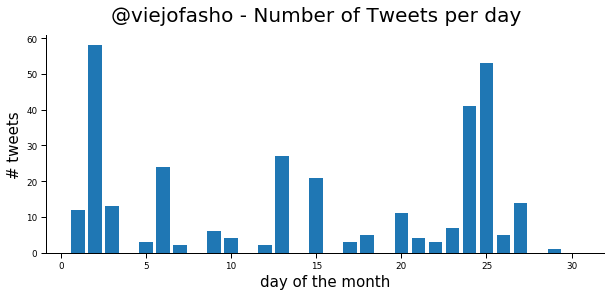

In [37]:
user_name = 'viejofasho'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @RResponsablecl


Info Data for @RResponsablecl

Name:                       Reg Responsable Cl
Name Length:                18
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    924982201434898433
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/924986249143836674/DKYiJprG_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            False
Has Description:            True
Description:                Buscamos transformar la política de drogas de Chile para regular democráticamente las vías de acceso al Cannabis medicinal y para el uso adulto.
Description length:         144
Account Active:             Active

Number of Tweets analyzed:          422
Last Tweet:                         2017-11-26T12:57:43.000000000
Older Tweet Analyzed:               2017-11-01T01:06:03.000000000
Account Active age (in days)        27.0
Average recent tweets per da

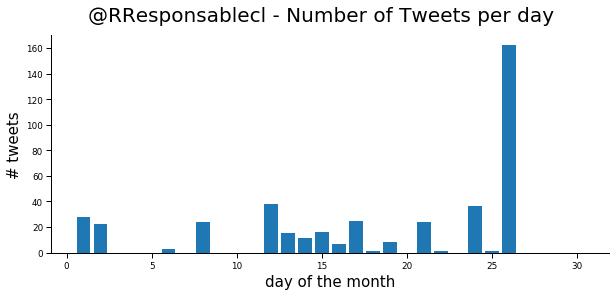

In [38]:
user_name = 'RResponsablecl'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @BassaRiveros


Info Data for @BassaRiveros

Name:                       Victor Riveros Bassa
Name Length:                20
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    927701598893170688
Default_Photo:              True
Photo URL:                  http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            False
Description:                
Description length:         0
Account Active:             Active

Number of Tweets analyzed:          501
Last Tweet:                         2017-11-30T22:57:18.000000000
Older Tweet Analyzed:               2017-11-07T01:23:42.000000000
Account Active age (in days)        23.0
Average recent tweets per day:      21.78
Maximum Recent Tweets Per Day:      55 at day 30
Average tweets per day since start: 0.39
Total Tweets since start:           9
Fo

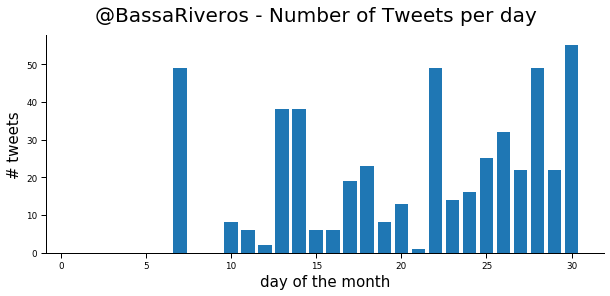

In [40]:
user_name = 'BassaRiveros'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

In [41]:
tweets[(tweets.user == user_name)& (tweets.day == 22)].text

917410     RT @rogofe47Chile: Acompañemos a @sebastianpin...
917682     RT @rogofe47Chile: @sebastianpinera estará jun...
917708     RT @paulinanu: Aquí el lote acompañando a nues...
917871     RT @Janocifuentes: Nuestro Presidente @sebasti...
918251     RT @amarielgg: 🇨🇱La gente sencilla de nuestro ...
918320     RT @paulanarvaezo: Sebastián Piñera critica a ...
918374     RT @Danielavy: Ahora; @joseantoniokast entrega...
918411     RT @canal13: Amigos recuerden, hoy después de ...
923467     RT @DR_FLORES: El comando de @sebastianpinera ...
923494     RT @EstoyConPinera: "Tengo mucha fe que podrem...
923562     RT @ErnestoSilvaM: Porque tiene programa d uni...
923652     RT @ErnestoSilvaM: Periodistas tratan de pilla...
924019     RT @twitabogado: #PiñeraEnEl13 #LasCarasdelaMo...
924324     RT @EstoyConPinera: "Tuve el privilegio que mi...
927239     RT @EstoyConPinera: "La Nueva Mayoría le pide ...
927690     RT @EstoyConPinera: "El tema que nos interesa ...
927793     RT @LucasPala

### @arqmneira


Info Data for @arqmneira

Name:                       Mario Neira
Name Length:                11
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    918734804283207681
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/918739720527638529/GrcERcgf_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            False
Description:                
Description length:         0
Account Active:             Active

Number of Tweets analyzed:          353
Last Tweet:                         2017-11-30T03:12:26.000000000
Older Tweet Analyzed:               2017-11-01T01:36:16.000000000
Account Active age (in days)        47.0
Average recent tweets per day:      12.17
Maximum Recent Tweets Per Day:      63 at day 17
Average tweets per day since start: 6.87
Total Tweets since start:           323
Followers_coun

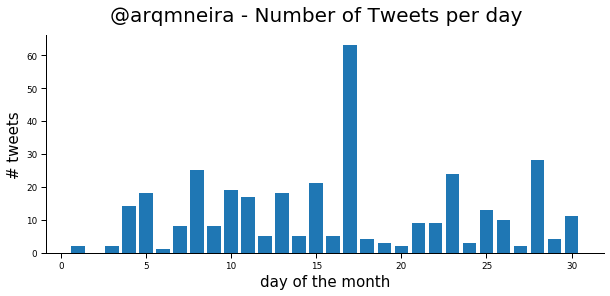

In [42]:
user_name = 'arqmneira'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @Ignacio90415476


Info Data for @Ignacio90415476

Name:                       JC
Name Length:                2
@user number Numeric Chars: 8
@user and name similarity:  0
User Id:                    894736543839129600
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/895064995205173252/lqS5bowW_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Providencia, Chile
default_profile:            True
Has Description:            False
Description:                
Description length:         0
Account Active:             Active

Number of Tweets analyzed:          349
Last Tweet:                         2017-11-30T23:58:34.000000000
Older Tweet Analyzed:               2017-11-01T15:22:15.000000000
Account Active age (in days)        114.0
Average recent tweets per day:      12.03
Maximum Recent Tweets Per Day:      50 at day 25
Average tweets per day since start: 3.3
Total Tweets since start:           376
F

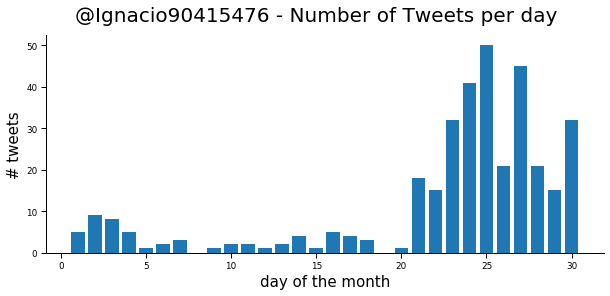

In [44]:
user_name = 'Ignacio90415476'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

In [46]:
result = get_botometer_details(user_name, prt=True)


Botometer Result for @Ignacio90415476

User Id:      894736543839129600
Score_eng:    0.46359219069702307
Score_unl:    0.19466773728450495
CAP_eng:      0.07583235670880943
CAP_unl:      0.012907437350993261

Categories:
Friend:      0.2447797639495201
Network:     0.22427046334856154
Sentiment:   0.5766607179829245
Temporal:    0.613204760264303
User:        0.538941031882933

Probability of @Ignacio90415476 be a bot is 19%


### @maasma58


Info Data for @maasma58

Name:                       Mauricio Silva Malig
Name Length:                20
@user number Numeric Chars: 2
@user and name similarity:  0
User Id:                    895660401827786753
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/924493489345302529/ya6rKblF_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Marga-Marga, Chile
default_profile:            True
Has Description:            True
Description:                Ingeniero Comercial MBA - Ex SEREMI de Economía Región de Valparaíso 2010 - 2014
Description length:         80
Account Active:             Not Active

Number of Tweets analyzed:          227
Last Tweet:                         2017-11-29T12:20:19.000000000
Older Tweet Analyzed:               2017-11-03T00:19:13.000000000
Account Active age (in days)        110.0
Average recent tweets per day:      8.73
Maximum Recent Tweets Per Day:     

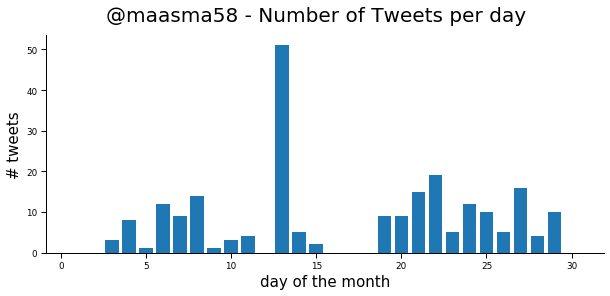

In [47]:
user_name = 'maasma58'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @Aptimate


Info Data for @Aptimate

Name:                       Botticelli
Name Length:                10
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    919677879444758533
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/919684439919222784/PxRwbhMC_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                Intolerante del abuso, la corrupción, la falta de equidad y del abuso institucionalizado.
Description length:         89
Account Active:             Active

Number of Tweets analyzed:          167
Last Tweet:                         2017-11-30T22:42:27.000000000
Older Tweet Analyzed:               2017-11-01T00:08:09.000000000
Account Active age (in days)        46.0
Average recent tweets per day:      5.76
Maximum Recent Tweets Per Day:      63 at day 23
Average t

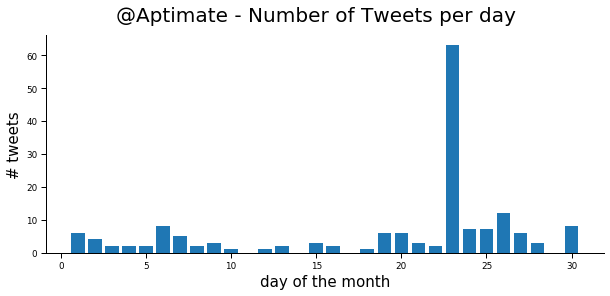

In [49]:
user_name = 'Aptimate'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

### @mas_estudiantil


Info Data for @mas_estudiantil

Name:                       Universitarios MAS
Name Length:                18
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    712410126234337280
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/712825553213132801/0aXsNp2a_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                Somos estudiantes universitari@s militantes y adherentes del @mas_juventud.
Description length:         75
Account Active:             Active

Number of Tweets analyzed:          75
Last Tweet:                         2017-11-29T12:41:42.000000000
Older Tweet Analyzed:               2017-11-01T01:32:52.000000000
Account Active age (in days)        616.0
Average recent tweets per day:      2.68
Maximum Recent Tweets Per Day:      52 at day 16
Average 

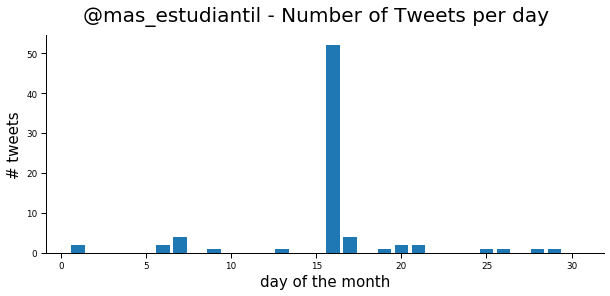

In [51]:
user_name = 'mas_estudiantil'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

## Conclusion

@mrgrtgautier ==> BOT
- 100% RT 
- 85% of all tweets have hashtags
- Almost all tweets (53/55) at a single day
- Young account: 12 days
- Active account - Last tweet dez/2017
- Pegabot: 82%
- Botometer: 22%

@ChristianPolo7 ==> BOT
- 87% RT 
- 97% of all tweets have mentions
- Very active account during elections and few months after
- Young account: 15 days
- Active account - Last tweet march/2018
- Botometer: No (22%)
- PegaBot: 41% (Network: 85%)

@Conapro_jjcc ==> BOT
- 0% RT 
- 85% of all tweets have a single mention (@Guillier)
- Only posting on 2 days same tweet/day
- Young account: 22 days
- Active account - Last tweet march/2018
- Botometer: Bot (92%)
- PegaBot: No (16%)

@Atletadelgol32 ==> BOT
- 97% RT
- 100% of all tweets have mentions
- Only posting on 2 days
- Young account: 3 days
- Not Active account 

@ElCentinelaMPE ==> BOT 
- 1% RT
- almost 100% of all tweets have hashtags, being #Elecciones on 96 of them
- Only posting on 5 days (81% of all tweets (114 at same day)
- Young account: created start of the month and do not post after nov/2017
- Active account 
- Botometer: No (28%)
- Pegabot: No find

@JuanManuelCorn5 ==> BOT 
- 1% RT
- 100% of all tweets have mentions: lot of them!
- Average text length per tweet: 654 (@XXX)
- Only posting few days after elections
- Young account: 92 days and do not post after dec/2017
- Active account 
- Pegabot: 47% (Network 58%)
- Botometer: No (28%)

@Santiag87306226 ==> BOT 
- 5% RT
- 99% of all tweets have mentions
- 89% have hashtags
- 70% of all tweets at same day (6/nov), almost all with same text
- Young account: 44 days
- Blocked account 

@SFelipeAlegreJ ==> Possible BOT or Cyborg
- 0% RT
- 100% of all tweets have mentions
- 88% have hashtags
- Almost all tweets at same day (23/nov), almost all with same text
- Young account: 93 days
- Active account 
- Botometer: no (34%)
- Pegabot: No found

@Trab_vXguillier' ==> Possible BOT or Cyborg
- 1 day with same tweet, having amost half of analysed tweets

@Sumate_Guillier ==> BOT
- 3% RT
- 195 tweets at same day (23/nov), almost all with two different text
- Young account: created after 1st round election
- Not Active account 

@viejofasho ==> Possible BOT or cyborg
- 0% RT
- 100% mentions, with multiples mentions on a single tweet
- Average text length per tweet: 344
- Young account: created end of october/17
- 5,725 in 9 months
- Active account, but w/o tweet sinse mid/18.
- PegaBot: 42% (77%:Network)
- Botometer: No (18%)
- weetBotOrNot: Error

@RResponsablecl ==> Possible BOT or cyborg
- one day (26/nov) with 162 tweets, 2 different texts.
- young account, created same month (nov/17)
- still active, but seems normal nowadays
- Pegabot Yes (66%)
- Botometer: No (24%)

@BassaRiveros ==> Possible BOT or cyborg
- one day (26/nov) with 162 tweets, 2 different texts.
- young account, created same month (nov/17)
- still active, but seems normal nowadays
- Pegabot Yes (100%)
- Botometer: No (36%)

@arqmneira ==> Possible NOT BOT
- PegaBot: 81%
- Botometer: no (10%)
- TweetBotOrNot: Error

@Ignacio90415476 ==> Possible a cyborg
- Account created 90 days before the start of nov/17
- Today is active and posted 6,000 tweets/year since 2017
- Botometer: No 
- PegaBot: Yes (76%)




@maasma58 ==> Possible bot
- Account created 90 days before the start of nov/17
- Today Blocked

@Aptimate ==> Possible cyborg
- Account created 10 days before the start of nov/17
- Today active
- Botometer: 14%
- PegaBot: 36%

@mas_estudiantil ==> Possible bot
- Few activity and one day with same tweet repeated
- Today active but w/o post
- Botometer: Not find
- PegaBot: Not Find

### @Choroy_Traiguen


Info Data for @Choroy_Traiguen

Name:                       Jorge Campos S.
Name Length:                15
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    309403232
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/901100549176741889/iTUEAUd1_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Osorno, Chile
default_profile:            False
Has Description:            True
Description:                #EmiliaNuyadoAncapichún
Desde el territorio al parlamento
Diputado Distrito 25
Description length:         78
Account Active:             Active

Number of Tweets analyzed:          63
Last Tweet:                         2017-11-14T17:28:52.000000000
Older Tweet Analyzed:               2017-11-14T17:28:52.000000000
Account Active age (in days)        2,357.0
Average recent tweets per day:      inf
Maximum Recent Tweets Per Day:      62 at day 14
Ave

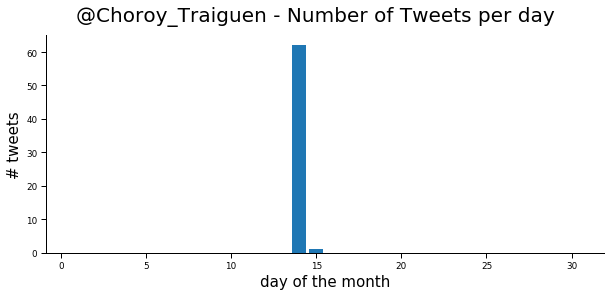

In [53]:
user_name = 'Choroy_Traiguen'
tw_day, metrics, mentions, hashtags = get_info_data(tweets, user_name, prt=True)

In [54]:
tweets[(tweets.user == user_name)& (tweets.day == 15)].text

488956    RT @Choroy_Traiguen: Piñera a Guillier por cad...
Name: text, dtype: object